# Sentiment Analysis from Movie Reviews
## Contributors: 
## Last Modified: 2/9/2020

## Importing necessary libraries

In [1]:
import pandas as pd
import re
from string import punctuation
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from wordcloud import WordCloud
from matplotlib import pyplot as plt


## Data Preprocessing

In [2]:
training_data = pd.read_csv('train.tsv', sep='\t') # read train data
test_data = pd.read_csv('test.tsv', sep='\t') # read test data

print("Training size: {}".format(training_data.shape[0]))
print("Test size: {}".format(test_data.shape[0]))

Training size: 156060
Test size: 66292


In [3]:
training_data['Sentiment'].value_counts() # Check the training data distribution among different sentiments

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

## Training data visualization in word cloud

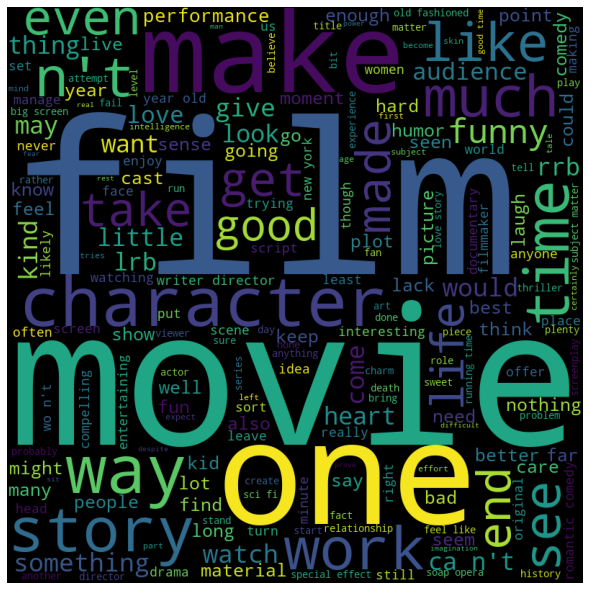

In [4]:
comment_words = ''
stopwords_set = set(stopwords.words("english"))

for val in training_data.Phrase: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords_set, 
                min_font_size = 10).generate(comment_words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [5]:
def preprocess(text):
    text = text.lower()
    text = ''.join([c for c in text if c not in punctuation]) # get rid of punctuations
    text = re.sub("[^a-zA-Z]"," ", text) # remove non-letters
    words = text.split()
    stops = set(stopwords.words("english"))
    words = [w for w in words if not w in stops] # removing stop words
    text = " ".join(words)

    return text

In [6]:
training_data.Phrase = training_data.Phrase.apply(lambda x: preprocess(x))
test_data.Phrase = test_data.Phrase.apply(lambda x: preprocess(x))

## Tokenize and/or vectorize the input data

In [7]:
vocab_size = 10000
max_len = 125

data = list(training_data.Phrase)
data.append(list(test_data.Phrase))
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data)

def tokenize_data(data):
    data = tokenizer.texts_to_sequences(data)
    data = pad_sequences(data, maxlen=max_len)
    return data

In [8]:
def format_data(training_data, test_data, vocab_size, max_len):
    train_X = training_data['Phrase']
    train_Y = to_categorical(training_data['Sentiment'].values)
    test_X = test_data['Phrase']

    train_X = tokenize_data(train_X)
    test_X = tokenize_data(test_X)
    return train_X, train_Y, test_X

In [9]:

train_X, train_Y, test_X = format_data(training_data, test_data, vocab_size, max_len)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.25)

## Prepare the model

In [10]:
model = Sequential()
model.add(Embedding(vocab_size, 100, mask_zero=True))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 1,085,125
Trainable params: 1,085,125
Non-trainable params: 0
_________________________________________________________________


## Model training

In [ ]:
# print(test_X.shape)
# weight_filepath = 'weights.hdf5'
# model.load_weights(weight_filepath)
# review = "the movie was not bad"
# processed_review = [preprocess(review)]
# tokenized_review = tokenize_data(processed_review[0:1])
# sentiment = model.predict_classes(tokenized_review)
# print(sentiment)